In [154]:
import sys
import os
from dotenv import load_dotenv
from enum import Enum
from typing import TypedDict, Annotated, List, Dict, Any, Optional
from langchain_openai import ChatOpenAI
from langchain_core.tools import Tool
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import add_messages, StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.utilities import GoogleSerperAPIWrapper

load_dotenv(override=True)

True

In [155]:

llm = ChatOpenAI(model="gpt-4o-mini")
serper = GoogleSerperAPIWrapper()
tool_web_search = Tool(
    name="web_search",
    func=serper.run,
    description="Useful for when you need more information from the web about a query"
)
tools = [tool_web_search]
llm_with_tools = llm.bind_tools(tools)


In [156]:
class Phase(str, Enum):
    GENERATE = "generate"
    VALIDATE = "validate"
    AUDIT = "audit"
    COMPLETE = "complete"

In [157]:
from langgraph.graph import add_messages
from operator import add

def merge_dicts(left: Dict[str, Any], right: Dict[str, Any]) -> Dict[str, Any]:
    """Merge two dictionaries, with right taking precedence over left."""
    result = left.copy()
    result.update(right)
    return result

def last_value(left: Any, right: Any) -> Any:
    """Keep the last value (right takes precedence)."""
    return right

class State(TypedDict):
    messages: Annotated[List, add_messages]
    user_problem: Annotated[str, last_value]
    current_phase: Annotated[Phase, last_value]
    iteration_count: Annotated[int, last_value]
    
    proposed_architecture: Annotated[Dict[str, Any], merge_dicts]
    architecture_components: Annotated[Dict[str, Dict[str, Any]], merge_dicts]

    validation_feedback: Annotated[List[Dict[str, Any]], add]
    audit_feedback: Annotated[List[Dict[str, Any]], add]

    active_agents: Annotated[List[str], add]
    completed_agents: Annotated[List[str], add]

    factual_errors_exist: Annotated[bool, last_value]
    design_flaws_exist: Annotated[bool, last_value]

    final_architecture: Annotated[Optional[Dict[str, Any]], last_value]
    architecture_summary: Annotated[Optional[str], last_value]
    

In [158]:
def architect_supervisor(state: State) -> State:
    """
    This function orchestrates the architecture generation process and coordinates the architect agents.
    """

    system_prompt = f"""
    You are a architect supervisor for AWS cloud architecture.
    Your role is to decompose the user's problem into smaller components on the basis of domain and assign them to different architect domain agents respectively.
    You will also be responsible for coordinating the work of these agents, ensuring that the overall architecture is aligned with the user's requirements and constraints.

    User Problem: {state["user_problem"]}
    Current Iteration: {state["iteration_count"]}

    Available feedback:
    - Validation feedback: {state["validation_feedback"]}
    - Audit feedback: {state["audit_feedback"]}

    Proposed Architecture: {state["proposed_architecture"]}

    Architecture Components: {state["architecture_components"]}

    Decompose the problem into tasks for:
    1. Compute Architect (EC2, Lambda, ECS, EKS, etc.)
    2. Network Architect (VPC, Subnets, ALB, CloudFront, Route 53, Security Groups, Route Tables, etc.)
    3. Storage Architect (S3, EBS, EFS, etc.)
    4. Database Architect (RDS, DynamoDB, ElastiCache, etc.)

    Provide clear instructions for each domain architect agent.
    """

    messages = [SystemMessage(content=system_prompt)]
    response = llm.invoke(messages)

    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=response.content))
    new_state["active_agents"] = ["compute_architect", "network_architect", "storage_architect", "database_architect"]
    new_state["completed_agents"] = []

    return new_state

In [159]:
memory = MemorySaver()

In [160]:
def create_initial_state(user_problem: str) -> State:
    """
    Create the initial state for the architecture generation process.
    """
    return {
        "messages": [HumanMessage(content=user_problem)],
        "user_problem": user_problem,
        "current_phase": Phase.GENERATE,
        "iteration_count": 0,
        "proposed_architecture": {},
        "architecture_components": {},
        "validation_feedback": [],
        "audit_feedback": [],
        "active_agents": [],
        "completed_agents": [], 
        "factual_errors_exist": False,
        "design_flaws_exist": False,
        "final_architecture": None,
        "architecture_summary": None
    }

In [161]:
def mark_agent_complete(state: State, agent_name: str) -> State:
    """
    Mark the specified agent as complete in the state.
    """
    new_state = state.copy()
    # For Annotated types, we return the new value to be added
    new_state["completed_agents"] = [agent_name]
    return new_state

In [162]:
def compute_architect(state: State) -> State:
    """
    This function implements the AWS compute architect agent.
    """

    system_prompt = f"""
    You are a compute architect for AWS cloud architecture.
    Your role is to design the compute infrastructure for the user's problem.

    Design compute components for: {state["user_problem"]}

    Consider: EC2 instances (types, sizes, placement groups), Lambda functions (serverless compute), ECS/EKS (container orchestration), Auto Scaling Groups, Load Balancers, etc.

    Use the web search only if you need more information about the compute pricing, features, or best practices.
    Provide detailed configuration recommendations.
    """

    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_tools.invoke(messages)

    new_state = mark_agent_complete(state, "compute_architect")
    new_state["messages"].append(AIMessage(content=response.content))
    # For Annotated types with merge_dicts, return the partial component to be merged
    new_state["architecture_components"] = {
        "compute": {
            "recommendations": response.content,
            "agent": "compute_architect"
        }
    }

    return new_state

In [163]:
def network_architect(state: State) -> State:
    """AWS network domain architect."""
    system_prompt = f"""
    You are a AWS Network Domain Architect.
    Design network infrastructure for: {state['user_problem']}
    
    Consider:
    - VPC design and subnets
    - Security Groups and NACLs
    - Load Balancers (ALB, NLB, CLB)
    - CloudFront/CDN
    - Route 53 DNS
    - VPN/Direct Connect
    - etc.
    
    Use the web search only if you need more information about the compute pricing, features, or best practices.
    Provide detailed network architecture.
    """
    
    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_tools.invoke(messages)
    
    new_state = mark_agent_complete(state, "network_architect")
    new_state["messages"].append(AIMessage(content=response.content))
    # For Annotated types with merge_dicts, return the partial component to be merged
    new_state["architecture_components"] = {
        "network": {
            "recommendations": response.content,
            "agent": "network_architect"
        }
    }
    
    return new_state

In [164]:
def storage_architect(state: State) -> State:
    """AWS storage domain architect."""
    system_prompt = f"""
    You are a AWS Storage Domain Architect.
    Design storage infrastructure for: {state['user_problem']}

    Consider: S3 buckets, EBS volumes, EFS file systems, etc.

    Use the web search only if you need more information about the storage pricing, features, or best practices.
    Provide detailed storage architecture.
    """

    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_tools.invoke(messages)

    new_state = mark_agent_complete(state, "storage_architect")
    new_state["messages"].append(AIMessage(content=response.content))
    # For Annotated types with merge_dicts, return the partial component to be merged
    new_state["architecture_components"] = {
        "storage": {
            "recommendations": response.content,
            "agent": "storage_architect"
        }
    }   

    return new_state


In [165]:
def database_architect(state: State) -> State:
    """AWS database domain architect."""
    system_prompt = f"""
    You are a AWS Database Domain Architect.
    Design database infrastructure for: {state['user_problem']}

    Consider: RDS, DynamoDB, ElastiCache, etc.

    Use the web search only if you need more information about the database pricing, features, or best practices.
    Provide detailed database architecture. 
    """         

    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_tools.invoke(messages)

    new_state = mark_agent_complete(state, "database_architect")
    new_state["messages"].append(AIMessage(content=response.content))
    # For Annotated types with merge_dicts, return the partial component to be merged
    new_state["architecture_components"] = {
        "database": {
            "recommendations": response.content,
            "agent": "database_architect"
        }
    }

    return new_state


In [166]:
def agent_completion_router(state: State) -> State:
    """
    This function implements the agent completion routing based on the active_agents and completed_agents.
    """
    if state["current_phase"] == Phase.GENERATE:
        required_agents = ["compute_architect", "network_architect", "storage_architect", "database_architect"]
        if all(agent in state["completed_agents"] for agent in required_agents):
            return "move_to_validation"
        else:
            return "continue_generation"

In [167]:
def phase_router(state: State) -> State:
    """
    This function implements the phase routing based on the current_phase and quality gates.
    """
    if state["current_phase"] == Phase.GENERATE:
        return "architect_supervisor"
    elif state["current_phase"] == Phase.VALIDATE:
        return "validator_supervisor"
    elif state["current_phase"] == Phase.AUDIT:
        return "auditor_supervisor"
    elif state["current_phase"] == Phase.COMPLETE:
        return "final_presenter"
    else:
        return "architect_supervisor"

In [168]:
def architect_coordinator(state: State) -> State:
    """
    Coordinates the completion of all architect agents.
    """
    new_state = state.copy()
    new_state["messages"].append({
        "role": "system",
        "content": "All architect agents have completed their tasks. Moving to validation phase."
    })

    return new_state

In [169]:
graph_builder = StateGraph(State)

graph_builder.add_node("architect_supervisor", architect_supervisor)
graph_builder.add_node("compute_architect", compute_architect)
graph_builder.add_node("network_architect", network_architect)
graph_builder.add_node("storage_architect", storage_architect)
graph_builder.add_node("database_architect", database_architect)
graph_builder.add_node("architect_coordinator", architect_coordinator)

# Parallel execution with Annotated types to handle multiple values
graph_builder.add_edge(START, "architect_supervisor")
graph_builder.add_edge("architect_supervisor", "compute_architect")
graph_builder.add_edge("architect_supervisor", "network_architect")
graph_builder.add_edge("architect_supervisor", "storage_architect")
graph_builder.add_edge("architect_supervisor", "database_architect")

graph_builder.add_edge("compute_architect", "architect_coordinator")
graph_builder.add_edge("network_architect", "architect_coordinator")
graph_builder.add_edge("storage_architect", "architect_coordinator")
graph_builder.add_edge("database_architect", "architect_coordinator")

# graph = graph_builder.compile(checkpointer=memory)
graph = graph_builder.compile()

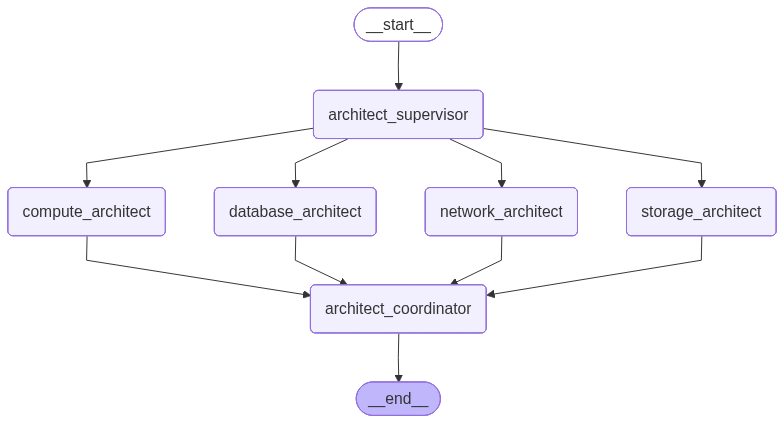

In [170]:
graph

In [175]:
result2 = graph.invoke(create_initial_state("I need to store 5 TB data."))

In [ ]:
print(result2)

{'messages': [HumanMessage(content='I need a scalable web application with a database and a storage system.', additional_kwargs={}, response_metadata={}, id='f6f08b34-597e-4265-b17f-d19301b54d21'), AIMessage(content="To address the user's requirement for a scalable web application with a database and a storage system, we can decompose the problem into tasks for each architectural domain. Here's how we can define the tasks for each domain architect agent:\n\n### 1. Compute Architect\n**Task Instructions:**\n- **Choose the Compute Model:** Assess whether to utilize serverless architecture (AWS Lambda), containerized services (ECS/EKS), or traditional virtual machines (EC2) based on scalability, cost, and deployment complexities.\n- **Scalability Considerations:** Plan for auto-scaling mechanisms. If using EC2, define auto-scaling groups; if using ECS or EKS, set up service auto-scaling.\n- **Load Balancing:** If you decide to use EC2, ensure that an Application Load Balancer (ALB) is con

In [173]:
for message in result['messages']:
    message.pretty_print()

================================ Human Message =================================

I need a scalable web application with a database and a storage system.
================================== Ai Message ==================================

To address the user's requirement for a scalable web application with a database and a storage system, we can decompose the problem into tasks for each architectural domain. Here's how we can define the tasks for each domain architect agent:

### 1. Compute Architect
**Task Instructions:**
- **Choose the Compute Model:** Assess whether to utilize serverless architecture (AWS Lambda), containerized services (ECS/EKS), or traditional virtual machines (EC2) based on scalability, cost, and deployment complexities.
- **Scalability Considerations:** Plan for auto-scaling mechanisms. If using EC2, define auto-scaling groups; if using ECS or EKS, set up service auto-scaling.
- **Load Balancing:** If you decide to use EC2, ensure that an Application Load Balancer

In [174]:
print(result)

{'messages': [HumanMessage(content='I need a scalable web application with a database and a storage system.', additional_kwargs={}, response_metadata={}, id='f6f08b34-597e-4265-b17f-d19301b54d21'), AIMessage(content="To address the user's requirement for a scalable web application with a database and a storage system, we can decompose the problem into tasks for each architectural domain. Here's how we can define the tasks for each domain architect agent:\n\n### 1. Compute Architect\n**Task Instructions:**\n- **Choose the Compute Model:** Assess whether to utilize serverless architecture (AWS Lambda), containerized services (ECS/EKS), or traditional virtual machines (EC2) based on scalability, cost, and deployment complexities.\n- **Scalability Considerations:** Plan for auto-scaling mechanisms. If using EC2, define auto-scaling groups; if using ECS or EKS, set up service auto-scaling.\n- **Load Balancing:** If you decide to use EC2, ensure that an Application Load Balancer (ALB) is con